In [1]:
pip install yfinance pandas numpy matplotlib seaborn scikit-learn plotly ta prophet


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=24aaefe440d390b51e6d4c8692dda0b18d9dc94ae52bcd91fb63387ae2a43c0a
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [11]:
import yfinance as yf
import pandas as pd

# Download stock data
data = yf.download('AAPL', start='2015-01-01', end='2024-12-31')
data.reset_index(inplace=True)


/tmp/ipython-input-11-3885085118.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('AAPL', start='2015-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed


In [12]:
# Force 'Close' to be a proper Series (1D)
close_series = data['Close']  # ✅ This is a Series

# Optional: Check its shape
print(close_series.shape)       # Should be (N,)
print(type(close_series))       # Should be <class 'pandas.core.series.Series'>


(2515, 1)
<class 'pandas.core.frame.DataFrame'>


In [14]:
print(type(data['Close']))
print(data['Close'].shape)
print(data[['Close']].shape)  # <- This is wrong usage


<class 'pandas.core.frame.DataFrame'>
(2515, 1)
(2515, 1)


In [15]:
# Force it to 1D Series
close_series = data[['Close']].squeeze()


In [16]:
import ta

# Force Close to 1D Series (safe fix)
close_series = data[['Close']].squeeze()

# SMA
sma = ta.trend.SMAIndicator(close=close_series, window=20)
data['SMA_20'] = sma.sma_indicator()

# EMA
ema = ta.trend.EMAIndicator(close=close_series, window=20)
data['EMA_20'] = ema.ema_indicator()

# RSI
rsi = ta.momentum.RSIIndicator(close=close_series, window=14)
data['RSI'] = rsi.rsi()

# Bollinger Bands
bb = ta.volatility.BollingerBands(close=close_series, window=20)
data['BB_high'] = bb.bollinger_hband()
data['BB_low'] = bb.bollinger_lband()


In [17]:
features = data[['Close', 'SMA_20', 'EMA_20', 'RSI', 'BB_high', 'BB_low']]


In [18]:
from sklearn.ensemble import IsolationForest

# Initialize model
iso_forest = IsolationForest(contamination=0.01, random_state=42)

# Fit and predict
data['anomaly'] = iso_forest.fit_predict(features)

# Convert output: -1 = anomaly, 1 = normal → make it binary
data['anomaly'] = data['anomaly'].map({1: 0, -1: 1})


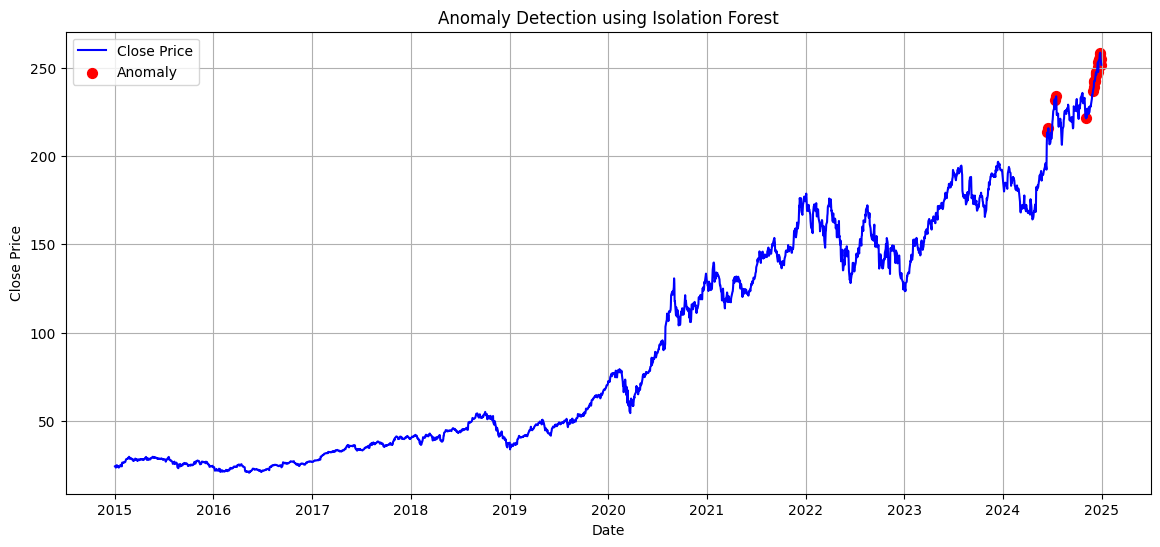

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(data['Date'], data['Close'], label='Close Price', color='blue')

# Plot anomalies as red dots
plt.scatter(
    data[data['anomaly'] == 1]['Date'],
    data[data['anomaly'] == 1]['Close'],
    color='red', label='Anomaly', s=50
)

plt.title('Anomaly Detection using Isolation Forest')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
!pip install prophet --quiet


In [25]:
import pandas as pd
import yfinance as yf
from prophet import Prophet

# Step 1: Download data
data = yf.download('AAPL', start='2015-01-01', end='2024-12-31')
data.reset_index(inplace=True)

# Step 2: Create Prophet-compatible dataframe
# Rename columns to 'ds' and 'y'
prophet_data = data[['Date', 'Close']].copy()
prophet_data.columns = ['ds', 'y']

# Step 3: Force correct data types
prophet_data['ds'] = pd.to_datetime(prophet_data['ds'])
prophet_data['y'] = prophet_data['y'].astype(float)  # Force to 1D float series

# Step 4: Drop missing values
prophet_data.dropna(inplace=True)

# ✅ Final check before model
print(prophet_data.dtypes)
print(prophet_data.shape)

# Step 5: Fit the model
model = Prophet(daily_seasonality=True)
model.fit(prophet_data)


/tmp/ipython-input-25-3794678521.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('AAPL', start='2015-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1t3_agsc/kqzn3s1w.json


ds    datetime64[ns]
y            float64
dtype: object
(2515, 2)


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1t3_agsc/8ht7zs_e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25791', 'data', 'file=/tmp/tmp1t3_agsc/kqzn3s1w.json', 'init=/tmp/tmp1t3_agsc/8ht7zs_e.json', 'output', 'file=/tmp/tmp1t3_agsc/prophet_modeld_tga1tg/prophet_model-20250626032408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:24:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:24:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [26]:
# Create a future DataFrame
future = model.make_future_dataframe(periods=180)

# Generate forecast
forecast = model.predict(future)

# Show forecast
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
2690,2025-06-24,250.222670,239.321835,261.811938
2691,2025-06-25,250.472082,239.435646,262.118708
2692,2025-06-26,250.732055,240.557129,261.788895
2693,2025-06-27,251.036678,239.925997,262.001535
2694,2025-06-28,250.655803,239.215871,262.074200


In [27]:
# Merge actual and forecasted values
merged = pd.merge(
    prophet_data,  # actual values
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    on='ds',
    how='left'
)

# Detect anomalies
merged['anomaly'] = 0
merged.loc[merged['y'] > merged['yhat_upper'], 'anomaly'] = 1   # Spike
merged.loc[merged['y'] < merged['yhat_lower'], 'anomaly'] = -1  # Drop


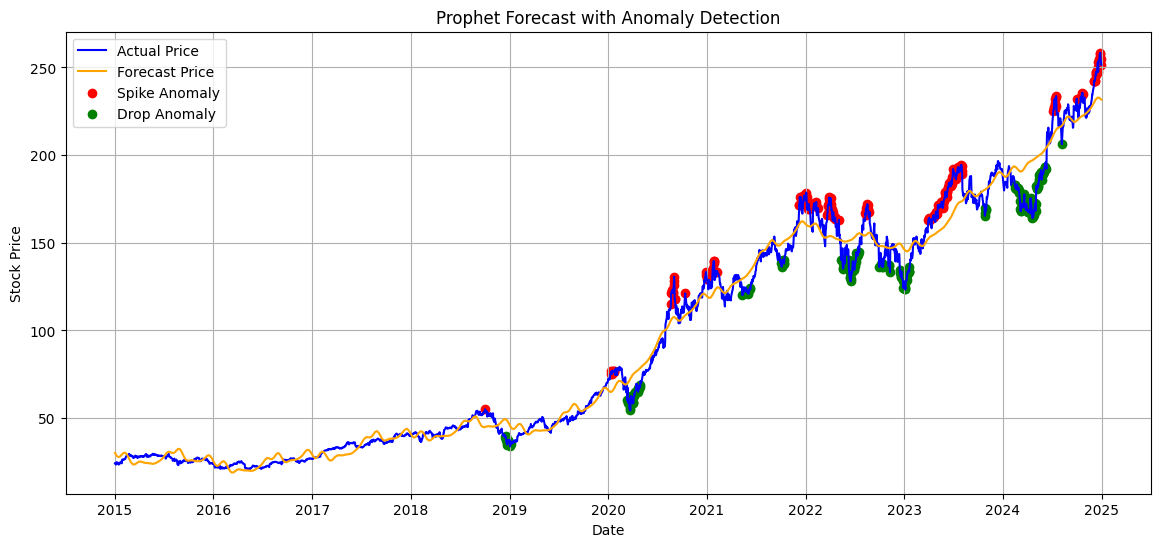

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Plot actual and forecast
plt.plot(merged['ds'], merged['y'], label='Actual Price', color='blue')
plt.plot(merged['ds'], merged['yhat'], label='Forecast Price', color='orange')

# Highlight anomalies
plt.scatter(merged[merged['anomaly'] == 1]['ds'], merged[merged['anomaly'] == 1]['y'],
            color='red', label='Spike Anomaly')
plt.scatter(merged[merged['anomaly'] == -1]['ds'], merged[merged['anomaly'] == -1]['y'],
            color='green', label='Drop Anomaly')

plt.title('Prophet Forecast with Anomaly Detection')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()
